In [1]:

import scipy as sc

import matplotlib.pylab as PLT
from matplotlib.ticker import MaxNLocator

import numpy as np

import F2O.constants as CTE

import F2O.F2O_utils as F2O
from fwOp.fwOperator import fwOp
from F2O.F2O_sptl import gd

import demo.synthData as sd


# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter
#

# Simple quadratic optimization problem

### Generate data

In [15]:
N = 500

synthData = sd.synthData()

A, b, xori = synthData.genData(N, 1.*N, normalize=True)


> $\large \begin{array}{rcl}
 B & = & \mbox{randn}(N,N) \\
 & \\
 A & = & B^TB + \alpha\cdot\mbox{diag}(N) \\
 A & /= & \| A \|_2^2 \qquad\qquad\qquad\qquad (\mbox{optional}) \\
 & \\
 \mathbf{x}_{\tiny\mbox{ORI}} & = & \mbox{randn}(N,1) \\
 & \\
 b & = & A\mathbf{x}_{\tiny\mbox{ORI}} + \sigma\cdot \mbox{randn}(N,1) 
\end{array}$


### Define optimization variable

In [16]:
args = F2O.argsF2O()

args.verbose    = True
args.fCostClass = CTE.cost_L2_lin      # F(x) = 0.5|| fAx(x) - b ||_2^2, where fAx is lineal
args.freqSol    = False                         


### Select forward operator 

In [17]:
Op       = fwOp()
Op.linOp = CTE.fAx_matrixvec
Op.A     = A
  


args.bShape    = b.shape
args.hShape    = A.shape


# Solve $F(\mathbf{x}) = 0.5|| \mbox{Op}(\mathbf{x}) - \mathbf{b} ||_2^2$ via GD 

$$ \large
\begin{array}{l}
\begin{array}{rcl}
\mbox{Init :} & & \mathbf{x}_0  - \mbox{ Initial solution}\\
 & & p_\alpha - \mbox{ Compute step-size (simplest case: } \alpha = \mbox{cte.)}\\
 & \\
\end{array} \\
\mathbf{\mbox{for }} k = 0,1,\ldots \\
 \quad \mathbf{g}_k = \nabla F(\mathbf{x}_k) \\
 \quad \alpha_k = p_\alpha(\cdot) \\
 \quad \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k\cdot \mathbf{g}_k
\end{array} 
$$

Python code (see  ` F2O_sptl.py ` )

```python
for k in range(nIter):   
    
    grad = computeGrad(x, b, None)
    
    gd.RecordStats(k, x, b, grad, gdStats, None, computeCost)   # --- statistics --
                    
    alpha = computeSS(k, grad, x)       # compute step-size
    
    x = x - alpha*grad                  # Gradient descent step
    
    gdStats[k,1] = alpha                # --- record step-Size ---
        
    if stopFunc(k, x, gdStats):         # check for exit condition / print stats
      print('Stop criteria -- iteration {0}'.format(k))
      break
```

In [18]:
nIter = 100

# Comment the next command out to avoid printing the cost function evolution
args.verbose   = False

x = []
Stats = []
ssPolicy = []

# Dummy call
args.ssPoliciy = CTE.ss_CauchyLagged
args.ssCte     = 0.
x0, gdStats0   = gd(Op, b, nIter, args)


Stop criteria -- iteration 35


In [19]:
# Cte. step-size (just one Cauchy call)

ssPolicy.append(CTE.ss_CteCauchy)
l = 0

args.ssPoliciy = ssPolicy[l]
args.gradL2 = 1
args.gradLi = 1

sol = gd(Op, b, nIter, args)
x.append(sol[0])
Stats.append(sol[1])

In [20]:
# Cauchy-BB

ssPolicy.append(CTE.ss_CauchyLagged)
l += 1

args.ssPoliciy = ssPolicy[l]
args.gradL2 = 1
args.gradLi = 1

sol = gd(Op, b, nIter, args)
x.append(sol[0])
Stats.append(sol[1])

Stop criteria -- iteration 35


In [21]:
# BBv1

ssPolicy.append(CTE.ss_BBv1)
l += 1

args.ssPoliciy = ssPolicy[l]
args.gradL2 = 1
args.gradLi = 1

sol = gd(Op, b, nIter, args)
x.append(sol[0])
Stats.append(sol[1])


Stop criteria -- iteration 32


[Text(0.5, 0, 'Time (sec.)')]

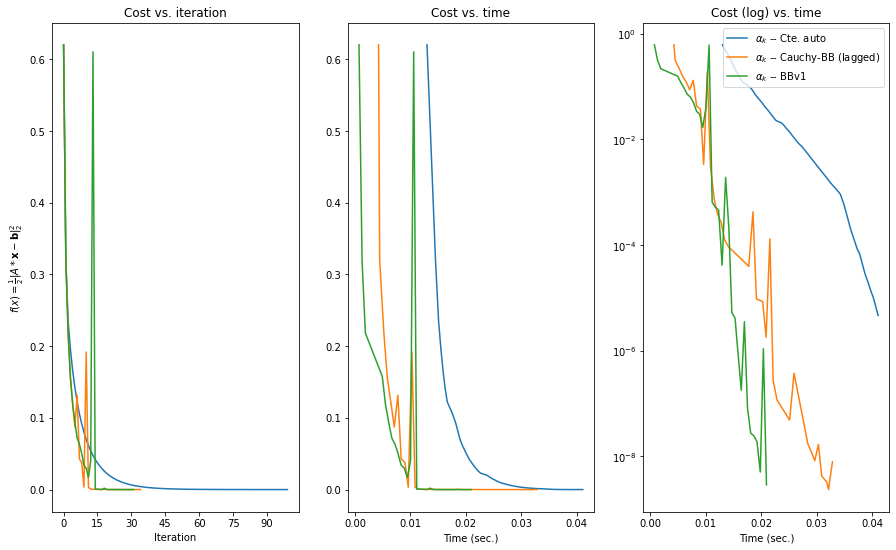

In [22]:
# Plot cost functional ---
figure, f = PLT.subplots(ncols=3, figsize=(15, 9))
  
for n in range(len(x)):
    f[0].plot(Stats[n][:,0], label=r'$\alpha_k$ -- {0}'.format(CTE.ss_list[ssPolicy[n]]) )
  
f[0].set_title('Cost vs. iteration')
f[0].xaxis.set_major_locator(MaxNLocator(integer=True))  
PLT.setp(f[0], xlabel='Iteration', 
           ylabel=r'$f(x) = \frac{1}{2}\left\| A * \mathbf{x} - \mathbf{b} \right\|_2^2 $')
  
  
for n in range(len(x)):
    f[1].plot(Stats[n][:,2], Stats[n][:,0], label=r'$\alpha_k$ -- {0}'.format(CTE.ss_list[ssPolicy[n]]) )

f[1].set_title('Cost vs. time')
PLT.setp(f[1], xlabel='Time (sec.)') 

    
for n in range(len(x)):
    f[2].semilogy(Stats[n][:,2], Stats[n][:,0], label=r'$\alpha_k$ -- {0}'.format(CTE.ss_list[ssPolicy[n]]) )
    
    
f[2].legend(loc='upper right',fontsize=10)
f[2].set_title('Cost (log) vs. time')
PLT.setp(f[2], xlabel='Time (sec.)') 
  

[Text(0.5, 0, 'Time (sec.)')]

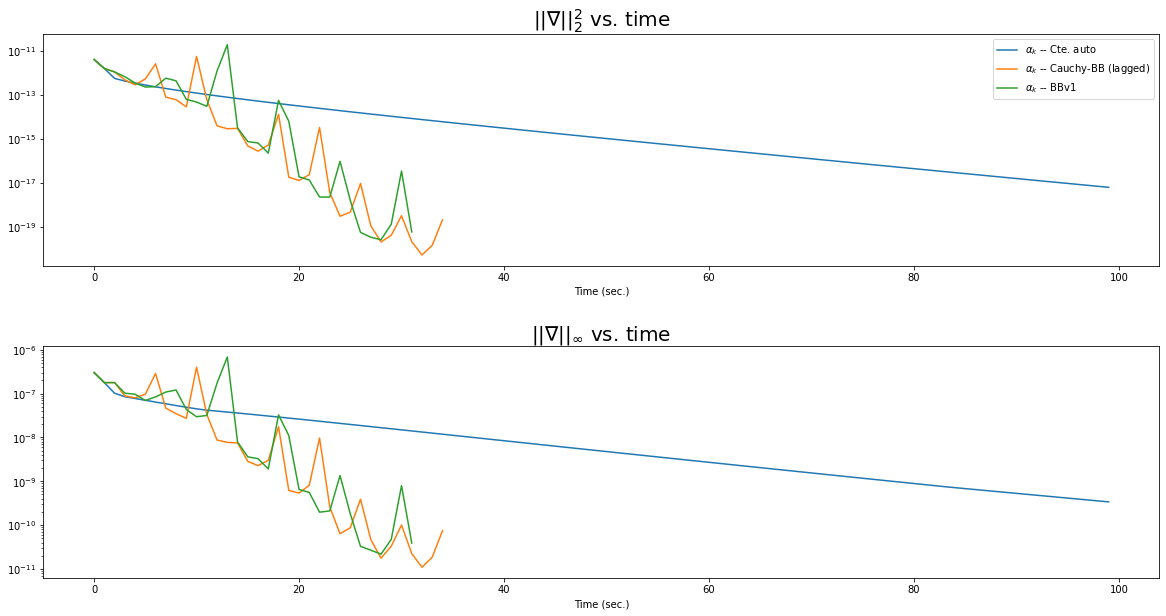

In [23]:
# Plot gradient norm

figure, f = PLT.subplots(nrows=2, figsize=(20, 10))
  
for n in range(len(x)):
    f[0].semilogy(Stats[n][:,3], label=r'$\alpha_k$ -- {0}'.format(CTE.ss_list[ssPolicy[n]]) )

f[0].set_title(r'$ \|\| \nabla \|\|_2^2 $ vs. time',fontsize=20)
PLT.setp(f[0], xlabel='Time (sec.)') 
f[0].legend(loc='upper right',fontsize=10)
PLT.subplots_adjust(hspace = 0.35)

for n in range(len(x)):
    f[1].semilogy(Stats[n][:,4], label=r'$\alpha_k$ -- {0}'.format(CTE.ss_list[ssPolicy[n]]) )

f[1].set_title(r'$ \|\| \nabla \|\|_\infty $ vs. time',fontsize=20)
PLT.setp(f[1], xlabel='Time (sec.)') 
    